In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

# Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/(With Miss Value) Kab Bekasi berdasarkan BBLA PBLA Februari 2024 (2255).xlsx'
df = pd.read_excel(file_path)
df.head()

,No,NIK,Nama,JK,Tgl Lahir,BB Lahir,TB Lahir,Nama Ortu,Prov,Kab/Kota,...,ZS BB/U,TB/U,ZS TB/U,BB/TB,ZS BB/TB,Naik Berat Badan,PMT Diterima (kg),Jml Vit A,KPSP,KIA
0,1 .,0112192716,RAFFASYA M,L,2019-12-01,2.2,45,SITI A,JAWA BARAT,BEKASI,...,1.36,Normal,2.64,Gizi Baik,-0.42,O,-,1.0,-,-
1,2 .,3216085206210001,SALMA NUR L,L,2021-06-12,2.4,46,syarif w,JAWA BARAT,BEKASI,...,4.49,Normal,1.28,Obesitas,5.38,O,-,1.0,-,-
2,3 .,3216715108209931,SHIFA.A,P,2021-02-02,1.93,40,SRI WIDODO,JAWA BARAT,BEKASI,...,0.93,Normal,-0.61,Risiko Gizi Lebih,1.77,O,-,1.0,-,-
3,4 .,3275056906200005,ASHALINA MELODY NASA,P,2020-06-29,2.2,46,NORWAN NASA MUSTOFA,JAWA BARAT,BEKASI,...,0.41,Normal,2.85,Gizi Baik,-1.97,O,-,1.0,-,-
4,5 .,1813036210190001,SHANUM SARASYA ALAMSAH,P,2019-10-22,2,42,SASTRA ALAMSAH,JAWA BARAT,BEKASI,...,-0.82,Normal,-1.36,Gizi Baik,0.04,O,-,1.0,-,-


# Feature Selection

In [ ]:
df.drop('No', axis=1, inplace=True)
df.drop('NIK', axis=1, inplace=True)
df.drop('Nama', axis=1, inplace=True)
df.drop('Tgl Lahir', axis=1, inplace=True)
df.drop('BB Lahir', axis=1, inplace=True)
df.drop('TB Lahir', axis=1, inplace=True)
df.drop('Nama Ortu', axis=1, inplace=True)
df.drop('Prov', axis=1, inplace=True)
df.drop('Kab/Kota', axis=1, inplace=True)
df.drop('Kec', axis=1, inplace=True)
df.drop('Pukesmas', axis=1, inplace=True)
df.drop('Desa/Kel', axis=1, inplace=True)
df.drop('Posyandu', axis=1, inplace=True)
df.drop('RT', axis=1, inplace=True)
df.drop('RW', axis=1, inplace=True)
df.drop('Alamat', axis=1, inplace=True)
df.drop('Tanggal Pengukuran', axis=1, inplace=True)
df.drop('LiLA', axis=1, inplace=True)
df.drop('Naik Berat Badan', axis=1, inplace=True)
df.drop('PMT Diterima (kg)', axis=1, inplace=True)
df.drop('Jml Vit A', axis=1, inplace=True)
df.drop('KPSP', axis=1, inplace=True)
df.drop('KIA', axis=1, inplace=True)

# Renaming All Feature and Categories

In [ ]:
df.rename(columns={
    'JK': 'Gender',
    'Usia Saat Ukur': 'Age_at_Measurement',
    'Berat': 'Weight',
    'Tinggi': 'Height',
    'BB/U': 'Weight/Age',
    'ZS BB/U': 'Weight/Age_ZS',
    'TB/U': 'Height/Age',
    'ZS TB/U': 'Height/Age_ZS',
    'BB/TB': 'Weight/Height',
    'ZS BB/TB': 'Weight/Height_ZS',
    }, inplace=True)

In [ ]:
df['Gender'] = df['Gender'].str.strip().map({'L': 'M', 'P': 'F'})

df['Weight/Age'] = df['Weight/Age'].map({
    'Sangat Kurang': 'Severely Underweight',
    'Kurang': 'Underweight',
    'Berat Badan Normal': 'Normal',
    'Risiko Lebih': 'Risk of OverWeight'
 })

df['Height/Age'] = df['Height/Age'].map({
    'Tinggi': 'Tall',
    'Normal': 'Normal',
    'Pendek': 'Stunted',
    'Sangat Pendek': 'Severely Stunted'
})

df['Weight/Height'] = df['Weight/Height'].map({
    'Gizi Buruk': 'Severely Wasted',
    'Gizi Kurang': 'Wasted',
    'Gizi Baik': 'Normal',
    'Risiko Gizi Lebih': 'Risk of Overweight',
    'Gizi Lebih': 'Overweight',
    'Obesitas': 'Obese'
 })

df['Age_at_Measurement'] = df['Age_at_Measurement'].str.replace('Tahun', 'Year').str.replace('Bulan', 'Month').str.replace('Hari', 'Day')

df.head()

,Gender,Age_at_Measurement,Weight,Height,Weight/Age,Weight/Age_ZS,Height/Age,Height/Age_ZS,Weight/Height,Weight/Height_ZS
0,M,4 Year - 2 Month - 13 Day,20.00,116.0,Risk of OverWeight,1.36,Normal,2.64,Normal,-0.42
1,M,2 Year - 8 Month - 5 Day,22.95,98.0,Risk of OverWeight,4.49,Normal,1.28,Obese,5.38
2,F,3 Year - 0 Month - 13 Day,15.76,93.0,Normal,0.93,Normal,-0.61,Risk of Overweight,1.77
3,F,3 Year - 7 Month - 25 Day,16.20,112.0,Normal,0.41,Normal,2.85,Normal,-1.97
4,F,4 Year - 4 Month - 2 Day,15.00,99.0,Normal,-0.82,Normal,-1.36,Normal,0.04


# Visualization

In [ ]:
# gender_counts = df['Gender'].value_counts()

# plt.figure(figsize=(6, 6))
# plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightpink'])
# plt.title('Distribution of Gender (Male vs Female)', fontsize=14)
# plt.show()

In [ ]:
# df['Stunting_Status'] = df['Height/Age'].map(lambda x: 'Normal' if x in ['Tall', 'Normal'] else 'Stunted')
# stunting_counts = df['Stunting_Status'].value_counts()

# plt.figure(figsize=(6, 4))
# colors = ['#ADD8E6', '#D3D3D3']
# wedges, texts, autotexts = plt.pie(stunting_counts, autopct='%1.1f%%', colors=colors, startangle=140)

# plt.legend(wedges, ['Normal', 'Stunting'], title="Status", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))
# plt.show()

# Handling Noise, Missing Value and Encoding Categories  

In [ ]:
zero_age_count = df[df['Age_at_Measurement'] == '0 Year - 0 Month - 0 Day'].shape[0]
print(f"Jumlah baris dengan '0 Tahun - 0 Bulan - 0 Hari' di kolom 'Age': {zero_age_count}")

Jumlah baris dengan '0 Tahun - 0 Bulan - 0 Hari' di kolom 'Age': 15


In [ ]:
df = df[df['Age_at_Measurement'] != '0 Year - 0 Month - 0 Day']
df.index = range(1, len(df) + 1)

In [ ]:
zero_age_count_after = df[df['Age_at_Measurement'] == '0 Year - 0 Month - 0 Day'].shape[0]
if zero_age_count_after > 0:
    print(f"Masih ada {zero_age_count_after} baris yang mengandung '0 Year - 0 Month - 0 Day'.")
else:
    print("Tidak ada lagi baris yang mengandung '0 Year - 0 Month - 0 Day'.")

Tidak ada lagi baris yang mengandung '0 Year - 0 Month - 0 Day'.


In [ ]:
def convert_to_months(age_str):
  pattern = r'(\d+)\s*Year\s*-\s*(\d+)\s*Month\s*-\s*(\d+)\s*Day'
  match = re.match(pattern, age_str)
  if match:
    years = int(match.group(1))
    months = int(match.group(2))
    days = int(match.group(3))

    total_months = years * 12 + months
    return total_months
  else:
        return None
df['Age_at_Measurement'] = df['Age_at_Measurement'].apply(convert_to_months)

<ipython-input-93-e0aea5f48802>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_at_Measurement'] = df['Age_at_Measurement'].apply(convert_to_months)


In [ ]:
df['Gender'] = df['Gender'].str.strip().map({'M': 0, 'F': 1})

df['Weight/Age'] = df['Weight/Age'].map({
    'Severely Underweight': 0,
    'Underweight': 1,
    'Normal': 2,
    'Risk of OverWeight': 3
 })

df['Height/Age'] = df['Height/Age'].map({
    'Normal': 0,
    'Tall': 0,
    'Stunted': 1,
    'Severely Stunted': 1
})

df['Weight/Height'] = df['Weight/Height'].map({
    'Severely Wasted': 0,
    'Wasted': 1,
    'Normal': 2,
    'Risk of Overweight': 3,
    'Overweight': 4,
    'Obese': 5
 })

df.head()

<ipython-input-94-6001626e9e56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'] = df['Gender'].str.strip().map({'M': 0, 'F': 1})
<ipython-input-94-6001626e9e56>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weight/Age'] = df['Weight/Age'].map({
<ipython-input-94-6001626e9e56>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,Gender,Age_at_Measurement,Weight,Height,Weight/Age,Weight/Age_ZS,Height/Age,Height/Age_ZS,Weight/Height,Weight/Height_ZS
1,0,50,20.00,116.0,3,1.36,0.0,2.64,2.0,-0.42
2,0,32,22.95,98.0,3,4.49,0.0,1.28,5.0,5.38
3,1,36,15.76,93.0,2,0.93,0.0,-0.61,3.0,1.77
4,1,43,16.20,112.0,2,0.41,0.0,2.85,2.0,-1.97
5,1,52,15.00,99.0,2,-0.82,0.0,-1.36,2.0,0.04


In [ ]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values) if not missing_values.empty else print("Tidak ada missing values.")

Height/Age       7
Weight/Height    3
dtype: int64


In [ ]:
df = df.dropna(subset=['Height/Age', 'Weight/Height'])
df = df.reset_index(drop=True)

print(df.isnull().sum())

Gender                0
Age_at_Measurement    0
Weight                0
Height                0
Weight/Age            0
Weight/Age_ZS         0
Height/Age            0
Height/Age_ZS         0
Weight/Height         0
Weight/Height_ZS      0
dtype: int64


In [ ]:
df['Height/Age'] = df['Height/Age'].astype(int)
df['Weight/Height'] = df['Weight/Height'].astype(int)

df.head()

,Gender,Age_at_Measurement,Weight,Height,Weight/Age,Weight/Age_ZS,Height/Age,Height/Age_ZS,Weight/Height,Weight/Height_ZS
0,0,50,20.00,116.0,3,1.36,0,2.64,2,-0.42
1,0,32,22.95,98.0,3,4.49,0,1.28,5,5.38
2,1,36,15.76,93.0,2,0.93,0,-0.61,3,1.77
3,1,43,16.20,112.0,2,0.41,0,2.85,2,-1.97
4,1,52,15.00,99.0,2,-0.82,0,-1.36,2,0.04


# Handling Outliers

In [ ]:
df.describe()

,Gender,Age_at_Measurement,Weight,Height,Weight/Age,Weight/Age_ZS,Height/Age,Height/Age_ZS,Weight/Height,Weight/Height_ZS
count,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000
mean,0.496190,30.796952,11.946014,87.309861,1.923353,-0.747051,0.066786,-0.780610,2.045719,-0.417813
std,0.500098,17.272818,3.656838,14.458745,0.439064,1.079470,0.249707,1.238054,0.452862,1.057071
min,0.000000,0.000000,2.500000,47.000000,0.000000,-5.780000,0.000000,-5.840000,0.000000,-5.270000
25%,0.000000,16.000000,9.300000,77.500000,2.000000,-1.430000,0.000000,-1.590000,2.000000,-1.130000
50%,0.000000,31.000000,12.000000,89.000000,2.000000,-0.730000,0.000000,-0.940000,2.000000,-0.420000
75%,1.000000,45.000000,14.600000,99.000000,2.000000,-0.030000,0.000000,-0.080000,2.000000,0.220000
max,1.000000,60.000000,31.190000,120.000000,3.000000,4.490000,1.000000,5.570000,5.000000,5.380000


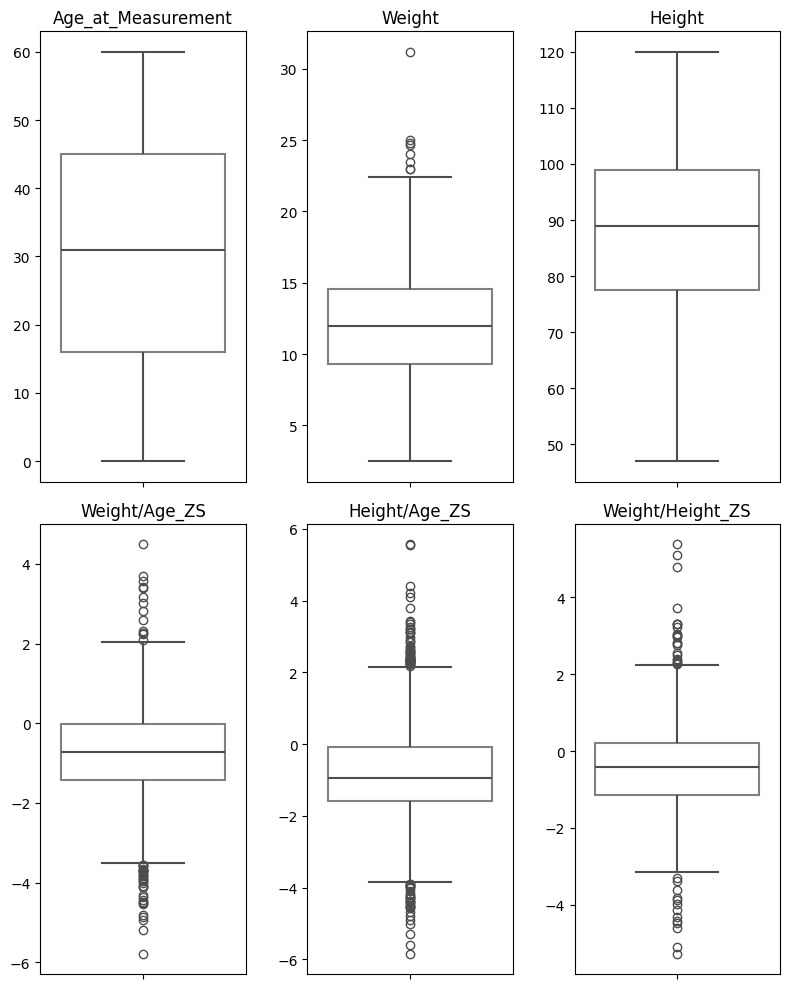

In [ ]:
features = ['Age_at_Measurement', 'Weight', 'Height', 'Weight/Age_ZS', 'Height/Age_ZS', 'Weight/Height_ZS']
plt.figure(figsize=(8, 10))

for i, feature in enumerate(features, 1):
    ax = plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature], linewidth=1.5, color='grey', boxprops=dict(edgecolor='grey', facecolor='none'), ax=ax)
    ax.set_title(feature)
    ax.set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

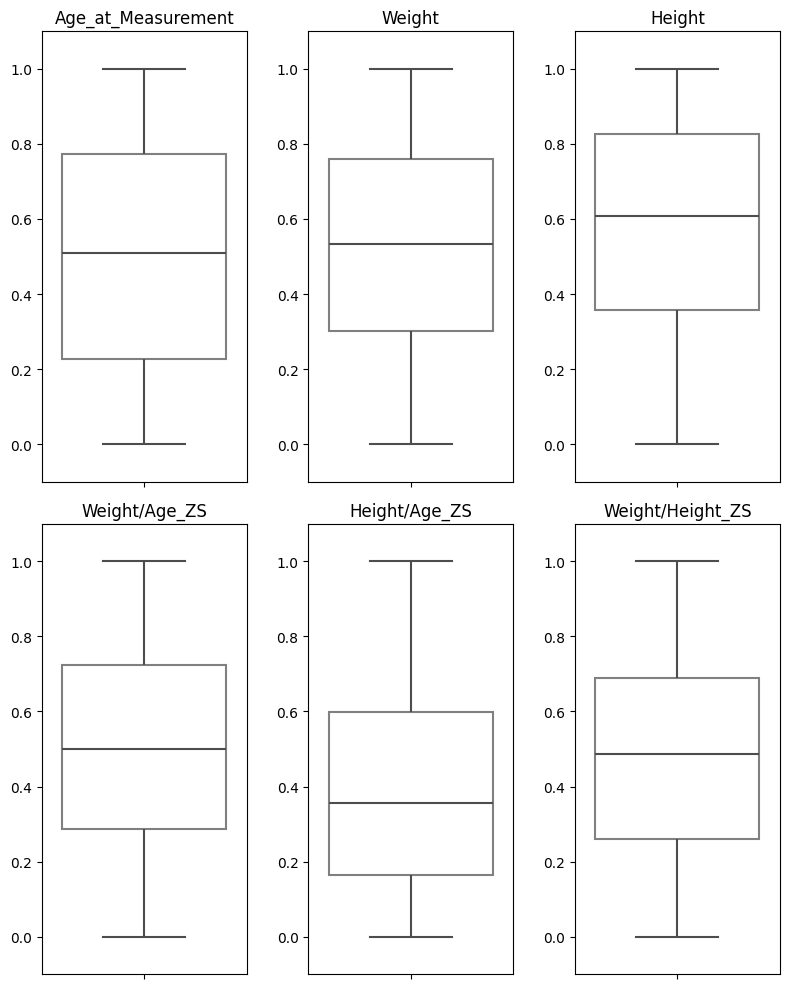

In [ ]:
# 1. Identifikasi outlier menggunakan IQR dan ganti dengan median jika ditemukan
def handle_outliers_with_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Batas bawah dan atas untuk mendeteksi outlier
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Ganti nilai outlier dengan median
        median = df[feature].median()
        df[feature] = df[feature].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

    return df

# 2. Winsorization untuk membatasi nilai ekstrem
def apply_winsorization(df, features, limits=[0.05, 0.05]):
    for feature in features:
        df[feature] = winsorize(df[feature], limits=limits)
    return df

# 3. Normalisasi fitur menggunakan MinMaxScaler
def scale_features(df, features):
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

# 4. Visualisasi boxplot untuk melihat hasil outlier handling
def plot_boxplots(df, features):
    plt.figure(figsize=(8, 10))  # Adjust the figure size for better visibility
    for i, feature in enumerate(features, 1):
        ax = plt.subplot(2, 3, i)  # Use a 2-row, 3-column grid layout
        sns.boxplot(y=df[feature], linewidth=1.5, color='grey',
                    boxprops=dict(edgecolor='grey', facecolor='none'), ax=ax)
        ax.set_title(feature)
        ax.set_ylabel('')

        # Set y-limits to ensure consistent height
        ax.set_ylim(df[feature].min() - 0.1, df[feature].max() + 0.1)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# Contoh penggunaan
features = ['Age_at_Measurement', 'Weight', 'Height', 'Weight/Age_ZS', 'Height/Age_ZS', 'Weight/Height_ZS']

# 1. Tangani outlier menggunakan IQR
df = handle_outliers_with_iqr(df, features)

# 2. Terapkan winsorization untuk membatasi nilai ekstrem
df = apply_winsorization(df, features)

# 3. Normalisasi fitur menggunakan Min-Max Scaling
col_to_scale = ['Age_at_Measurement', 'Weight', 'Height', 'Weight/Age_ZS', 'Height/Age_ZS', 'Weight/Height_ZS']
df = scale_features(df, col_to_scale)

# 4. Visualisasi hasil menggunakan boxplot
plot_boxplots(df, col_to_scale)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231 entries, 0 to 2230
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              2231 non-null   int64  
 1   Age_at_Measurement  2231 non-null   float64
 2   Weight              2231 non-null   float64
 3   Height              2231 non-null   float64
 4   Weight/Age          2231 non-null   int64  
 5   Weight/Age_ZS       2231 non-null   float64
 6   Height/Age          2231 non-null   int64  
 7   Height/Age_ZS       2231 non-null   float64
 8   Weight/Height       2231 non-null   int64  
 9   Weight/Height_ZS    2231 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 174.4 KB


# Splitting Data, Handling Imbalance Data and Model Evaluation

In [ ]:
# Split the data into features and target
X = df.drop(columns=['Height/Age'])
y = df['Height/Age']

# Split data into training and test sets with 70% data train and 30% data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
# Initialize SMOTE and RandomUnderSampler
smote = SMOTE(random_state=42)

# Apply the hybrid resampling to balance the dataset
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

y_train_res.describe()

,Height/Age
count,2504.0000
mean,0.5000
std,0.5001
min,0.0000
25%,0.0000
50%,0.5000
75%,1.0000
max,1.0000


In [ ]:
# Function to display evaluation metrics
def display_evaluation_metrics(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"\nModel: {model_name}")
    print(f"Accuracy\t: {accuracy*100:.2f}%")
    print(f"Precision\t: {precision*100:.2f}%")
    print(f"Recall\t\t: {recall*100:.2f}%")
    print(f"F1-Score\t: {f1*100:.2f}%")
    print(f"Classification Report:\n", classification_report(y_true, y_pred))
    return accuracy, precision, recall, f1, confusion_matrix(y_true, y_pred)

# Initialize and fit the Random Forest model
rf = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, n_estimators=100)
rf.fit(X_train_res, y_train_res)

# Initialize and fit the KNN model
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=5, weights='distance')
knn.fit(X_train_res, y_train_res)

# Evaluate Random Forest
print('---------------------------------------------------------------------------------------')
print("\nRandom Forest")
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_cm = display_evaluation_metrics("Random Forest", y_test, rf.predict(X_test))

# Evaluate KNN
print('\n---------------------------------------------------------------------------------------')
print("\nKNN")
knn_accuracy, knn_precision, knn_recall, knn_f1, knn_cm = display_evaluation_metrics("KNN", y_test, knn.predict(X_test))

print('---------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------

Random Forest

Model: Random Forest
Accuracy	: 99.22%
Precision	: 98.03%
Recall		: 95.91%
F1-Score	: 96.94%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       830
           1       0.97      0.92      0.94        63

    accuracy                           0.99       893
   macro avg       0.98      0.96      0.97       893
weighted avg       0.99      0.99      0.99       893


---------------------------------------------------------------------------------------

KNN

Model: KNN
Accuracy	: 96.19%
Precision	: 83.46%
Recall		: 92.08%
F1-Score	: 87.16%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       830
           1       0.68      0.87      0.76        63

    accuracy                           0.96       893
   macro avg       0.83      0.9

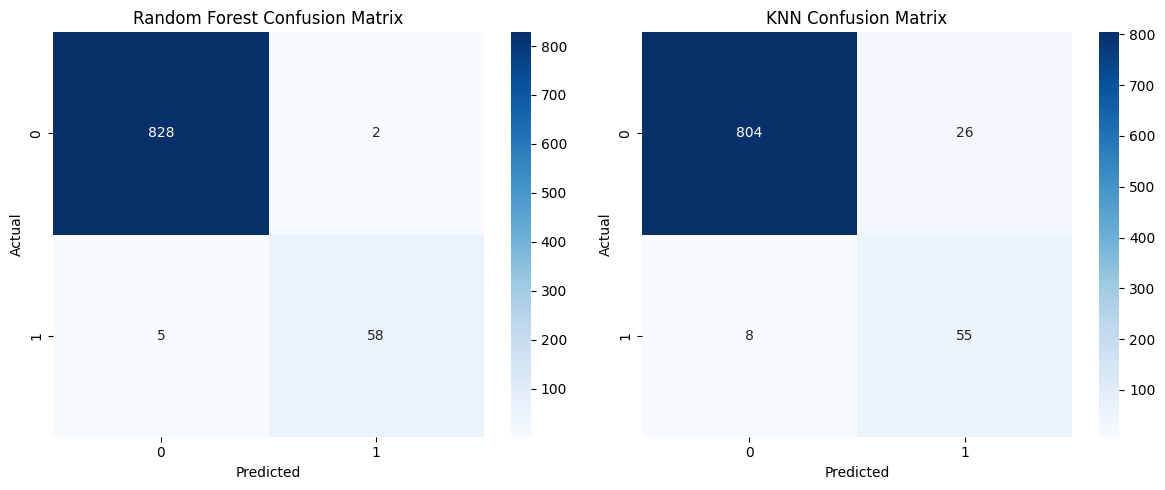

In [ ]:
# Plotting Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix untuk Random Forest
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Random Forest Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Confusion Matrix untuk KNN
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('KNN Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()